# PySpark with Neural Networks
Pyspark implementation of Shallow Neural Network from scratch using MNIST.

The goal of this project is to use Spark to build a 3 layer Neural Network from Scratch, using my own mathematical formulas to solve an Image classification Task. I will use the very famous MNIST dataset

## Generate Dataset

In [ ]:
import numpy as np
import os

import sys
import pyspark
import random
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from pyspark import SparkContext as sc

print("Pyspark Script:", sys.argv[0])
print("PySpark version:", pyspark.__version__)

from keras.datasets import mnist
from keras.utils import to_categorical

# Initialize SparkContext
sc = sc.getOrCreate()

Pyspark Script: /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py
PySpark version: 3.5.1


In [ ]:
print('Start downloading dataset...')
# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Start downloading dataset...


In [ ]:
# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train).reshape(-1, 10)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = to_categorical(y_test)

In [ ]:
if not os.path.exists('data/'):
    os.makedirs('data/')


np.savetxt('data/mnist_images_train.csv', x_train.reshape(len(x_train),784).tolist())
np.savetxt('data/mnist_images_test.csv', x_test.reshape(len(x_test),784).tolist())
np.savetxt('data/mnist_labels_train.csv', y_train.tolist())
np.savetxt('data/mnist_labels_test.csv', y_test.tolist())

print('Dataset downloaded.')

print('Data is located here:', os.getcwd() + '\data')

Dataset downloaded.
Data is located here: /content\data


## Load the dataset

In [ ]:
txt_train_images = sc.textFile("data/mnist_images_train.csv", 1)
x_train = txt_train_images.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 784)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_train_labels = sc.textFile("data/mnist_labels_train.csv", 1)
y_train = txt_train_labels.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 10)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_test_images = sc.textFile("data/mnist_images_test.csv", 1)
x_test = txt_test_images.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 784)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_test_labels = sc.textFile("data/mnist_labels_test.csv", 1)
y_test = txt_test_labels.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 10)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

In [ ]:
train_ds_rdd = x_train.join(y_train).map(lambda x: x[1])
test_ds_rdd = x_test.join(y_test).map(lambda x: x[1])

# train_rdd = train_ds_rdd.filter(lambda x: np.array_equal(x[1][0], [1., 0.]) or np.array_equal(x[1][0], [0., 1.]))
# test_rdd = test_ds_rdd.filter(lambda x: np.array_equal(x[1][0], [1., 0.]) or np.array_equal(x[1][0], [0., 1.]))

train_rdd = train_ds_rdd
test_rdd = test_ds_rdd

train_rdd.cache()
test_rdd.cache()
print(train_rdd.take(1))
print("Trainset size:", train_rdd.count())
print("Testset size:", test_ds_rdd.count())

[(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

In [ ]:
# train_rdd = x_train.join(y_train).map(lambda x: x[1])
# test_rdd = x_test.join(y_test).map(lambda x: x[1])
# train_rdd.cache()
# test_rdd.cache()

# print("Trainset size:", train_rdd.count())
# print("Testset size:", test_rdd.count())

# print('Data Loaded!')

Data Loaded!


## NN Functions

### Activation Functions

In [ ]:
# # General function to apply any activation function
def activation(x, f):
    return f(x)

# # Sigmoid Activation function
# def sigmoid(X):
#     return 1 / (1 + np.exp(-X))

# # Sigmoid prime function (used for backward prop)
# def sigmoid_prime(x):
#     sig = sigmoid(x)
#     return sig * (1 - sig)

# --- Neural Network Functions for Multiclass ---
def softmax(z):
    e_z = np.exp(z - np.max(z))
    return e_z / np.sum(e_z, axis=1, keepdims=True)

def cross_entropy(y_pred, y_true, eps=1e-8):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(float)

### Forward Propagation

In [ ]:
# Compute the layer propagation before activation
def preforward(x, w, b):
    return np.dot(x, w) + b

# Compute the layer propagation after activation
# This is also equivalent to a predict function once model is trained
# def predict(x, W1, B1, W2, B2):
#     return sigmoid(preforward(sigmoid(preforward(x , W1, B1)), W2, B2))

def predict(x, W1, B1, W2, B2):
    h1 = relu(preforward(x, W1, B1))
    out = softmax(preforward(h1, W2, B2))
    return out

### Backward Propagation

In [ ]:
# # Compute the derivative of the error regarding B2
# def derivativeB2(y_pred, y_true, y_h, f_prime):
#     return (y_pred - y_true) * f_prime(y_h)

# # Compute the derivative of the error regarding W2
# def derivativeW2(h, dB2):
#     return np.dot(h.T, dB2)

# # Compute the derivative of the error regarding B1
# def derivativeB1(h_h, dB2, W2, f_prime):
#     return np.dot(dB2, W2.T) * f_prime(h_h)

# # Compute the derivative of the error regarding W1
# def derivativeW1(x, dB1):
#     return np.dot(x.T, dB1)

def derivativeB2(y_pred, y_true):
    # dL/dB2 = y_pred - y_true
    return y_pred - y_true  # shape: (1, 10)

def derivativeW2(h, dB2):
    # dL/dW2 = h.T @ (y_pred - y_true)
    return np.dot(h.T, dB2)  # shapes: (64, 1)T @ (1, 10) => (64, 10)

def derivativeB1(dB2, W2, h_h):
    # dL/dB1 = (y_pred - y_true) @ W2.T * relu'(h_h)
    return np.dot(dB2, W2.T) * relu_prime(h_h)

def derivativeW1(x, dB1):
    # dL/dW1 = x.T @ dB1
    return np.dot(x.T, dB1)

### Evaluation

In [ ]:
def get_metrics(pred, true):
    cm = multilabel_confusion_matrix(true, pred)
    return (cm)

# Cost function
def sse(y_pred, y_true):
    return 0.5 * np.sum(np.power(y_pred - y_true, 2))


# from sklearn.metrics import confusion_matrix

# def get_metrics(pred, true):
#     pred_labels = np.argmax(pred, axis=1)
#     true_labels = np.argmax(true, axis=1)
#     cm = confusion_matrix(true_labels, pred_labels)
#     return cm

## Training Mini Batch

In [ ]:
# Hyperparameters
num_iteration = 50
learningRate = 0.1

input_layer = 784 # number of neurones in the input layer (equal to image size)
hidden_layer = 64 # number of neurones in the hidden layer (Custom)
output_layer = 10 # number of neurones in the output layer (equal to the number of possible labels)

# Paramater Initialization
W1 = np.random.rand(input_layer, hidden_layer) - 0.5 # Shape (784, 64)
W2 = np.random.rand(hidden_layer, output_layer) - 0.5 # Shape (64, 10)
B1 = np.random.rand(1, hidden_layer) - 0.5 # Shape (1, 64)
B2 = np.random.rand(1, output_layer) - 0.5 # Shape (1, 10)

# History over epochs
cost_history = []
acc_history = []

In [ ]:
# # Epoch Loop (mini batch implementation)
# print("Start Training Loop:")

# for i in range(num_iteration):

#     # Compute gradients, cost and accuracy over mini batch

#     ################## Notations ######################
#     # x -> Input Image flatten of shape (1, 784)
#     # y* -> One hot label of shape (1, 2)
#     # h^ -> Forward prop from Input layer to hidden layer before activation (1, 64) using W1, B1 parm
#     # h -> Forward prop from Input layer to hidden layer after tanh activation (1, 64)
#     # y^ -> Forward prop from hidden layer to output layer before activation (1, 2) using W2, B2 parm
#     # y -> Forward prop from hidden layer to output layer after sigmoid activation (1, 2)
#     # E -> Error between y and y* using SSE
#     # Acc -> 1 is right prediction 0 otherwise
#     # DE/D? -> Partial derivative of the Error regarding parmaters (B2, W2, B1, W1)


#     ################# Forward Prop ######################
#     # map batch ([x], [y*]) to ([x], [h^],[y*])
#     # map batch ([x], [h^],[y*]) to ([x], [h^], [h], [y*])
#     # map batch ([x], [h^], [h], [y*]) to ([x], [h^], [h], [y^], [y*])
#     # map batch ([x], [h^], [h], [y^], [y*]) to ([x], [h^], [h], [y^], [y], [y*])
#     ################# Backward Prop #####################
#     # map batch ([x], [h^], [h], [y^], [y], [y*]) to ([x], [h^], [h], [E], [DE/DB2], [Acc])
#     # map batch ([x], [h^], [h], [E], [DE/DB2], [Acc]) to ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc])
#     # map batch ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc]) to ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc])
#     # map batch ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc]) to ([E], [DE/DB2], [DE/DW2], [DE/DB1], [DE/DW1],[Acc])
#     ############### Reduce over the mini batch #########


    # gradientCostAcc = train_rdd\
    #                     .sample(False,0.7)\
    #                     .map(lambda x: (x[0], preforward(x[0], W1, B1), x[1]))\
    #                     .map(lambda x: (x[0], x[1], activation(x[1], sigmoid), x[2]))\
    #                     .map(lambda x: (x[0], x[1], x[2], preforward(x[2], W2, B2), x[3]))\
    #                     .map(lambda x: (x[0], x[1], x[2], x[3], activation(x[3], sigmoid), x[4]))\
    #                     .map(lambda x: (x[0], x[1], x[2], sse(x[4], x[5]), derivativeB2(x[4], x[5], x[3], sigmoid_prime), int(np.argmax(x[4]) == np.argmax(x[5]))))\
    #                     .map(lambda x: (x[0], x[1], x[3], x[4],  derivativeW2(x[2], x[4]) ,x[5]))\
    #                     .map(lambda x: (x[0], x[2], x[3], x[4],  derivativeB1(x[1],  x[3], W2, sigmoid_prime) ,x[5]))\
    #                     .map(lambda x: (x[1], x[2], x[3], x[4], derivativeW1(x[0], x[4]) ,x[5], 1)) \
    #                     .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3], x[4] + y[4], x[5] + y[5], x[6] + y[6]))

#     # Cost and Accuarcy of the mini batch
#     n = gradientCostAcc[-1] # number of images in the mini batch
#     cost = gradientCostAcc[0]/n # Cost over the mini batch
#     acc = gradientCostAcc[5]/n # Accuarcy over the mini batch

#      # Add to history
#     cost_history.append(cost)
#     acc_history.append(acc)


#     # Extract gradiends
#     DB2 = gradientCostAcc[1]/n
#     DW2 = gradientCostAcc[2]/n
#     DB1 = gradientCostAcc[3]/n
#     DW1 = gradientCostAcc[4]/n

#     # Update parameter with new learning rate and gradients using Gradient Descent
#     B2 -= learningRate * DB2
#     W2 -= learningRate * DW2
#     B1 -= learningRate * DB1
#     W1 -= learningRate * DW1

#     # Display performances
#     print(f"   Epoch {i+1}/{num_iteration} | Cost: {cost_history[i]} | Acc: {acc_history[i]*100} | Batchsize:{n}")

# print("Training end..")

# # Plot of cost over epochs
# plt.subplot(2, 1, 1)
# plt.plot(cost_history)
# plt.show()

# # Plot of accuracy over epochs
# plt.subplot(2, 1, 2)
# plt.plot(acc_history)
# plt.show()

In [ ]:
# Epoch Loop (mini batch implementation)
print("Start Training Loop:")

for i in range(num_iteration):

    # Compute gradients, cost and accuracy over mini batch

    ################## Notations ######################
    # x -> Input Image flatten of shape (1, 784)
    # y* -> One hot label of shape (1, 2)
    # h^ -> Forward prop from Input layer to hidden layer before activation (1, 64) using W1, B1 parm
    # h -> Forward prop from Input layer to hidden layer after tanh activation (1, 64)
    # y^ -> Forward prop from hidden layer to output layer before activation (1, 2) using W2, B2 parm
    # y -> Forward prop from hidden layer to output layer after sigmoid activation (1, 2)
    # E -> Error between y and y* using SSE
    # Acc -> 1 is right prediction 0 otherwise
    # DE/D? -> Partial derivative of the Error regarding parmaters (B2, W2, B1, W1)


    ################# Forward Prop ######################
    # map batch ([x], [y*]) to ([x], [h^],[y*])
    # map batch ([x], [h^],[y*]) to ([x], [h^], [h], [y*])
    # map batch ([x], [h^], [h], [y*]) to ([x], [h^], [h], [y^], [y*])
    # map batch ([x], [h^], [h], [y^], [y*]) to ([x], [h^], [h], [y^], [y], [y*])
    ################# Backward Prop #####################
    # map batch ([x], [h^], [h], [y^], [y], [y*]) to ([x], [h^], [h], [E], [DE/DB2], [Acc])
    # map batch ([x], [h^], [h], [E], [DE/DB2], [Acc]) to ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc])
    # map batch ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc]) to ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc])
    # map batch ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc]) to ([E], [DE/DB2], [DE/DW2], [DE/DB1], [DE/DW1],[Acc])
    ############### Reduce over the mini batch #########


    gradientCostAcc = train_rdd\
                        .sample(False,0.7)\
                        .map(lambda x: (x[0], preforward(x[0], W1, B1), x[1]))\
                        .map(lambda x: (x[0], x[1], activation(x[1], relu), x[2]))\
                        .map(lambda x: (x[0], x[1], x[2], preforward(x[2], W2, B2), x[3]))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], activation(x[3], softmax), x[4]))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], cross_entropy(x[4], x[5]), derivativeB2(x[4], x[5]), int(np.argmax(x[4]) == np.argmax(x[5]))))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], derivativeW2(x[2], x[7])))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], derivativeB1(x[7], W2, x[1])))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], derivativeW1(x[0], x[10]), 1)) \
                        .reduce(lambda x, y: tuple(a + b if isinstance(a, np.ndarray) else a + b for a, b in zip(x, y)))

    print(gradientCostAcc)

    #
    # Cost and Accuarcy of the mini batch
    n = gradientCostAcc[-1] # number of images in the mini batch
    cost = gradientCostAcc[6]/n # Cost over the mini batch
    acc = gradientCostAcc[8]/n # Accuarcy over the mini batch

     # Add to history
    cost_history.append(cost)
    acc_history.append(acc)


    # Extract gradiends
    DB2 = gradientCostAcc[7]/n
    DW2 = gradientCostAcc[9]/n
    DB1 = gradientCostAcc[10]/n
    DW1 = gradientCostAcc[11]/n

    # Update parameter with new learning rate and gradients using Gradient Descent
    B2 -= learningRate * DB2
    W2 -= learningRate * DW2
    B1 -= learningRate * DB1
    W1 -= learningRate * DW1

    # Display performances
    print(f"   Epoch {i+1}/{num_iteration} | Cost: {cost_history[i]} | Acc: {acc_history[i]*100} | Batchsize:{n}")

print("Training end..")

# Plot of cost over epochs
plt.subplot(2, 1, 1)
plt.plot(cost_history)
plt.show()

# Plot of accuracy over epochs
plt.subplot(2, 1, 2)
plt.plot(acc_history)
plt.show()

Start Training Loop:
   Epoch 1/50 | Cost: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.18128010e-05 4.40636225e-05 2.02505160e-05 8.43771529e-07
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.50019146e-07 5.22200819e-05 1.35378450e-04
  2.09067828e-04 2.56225281e-04 5.28575970e-04 7.38581320e-04
  7.72332182e-04 7.21705893e-04 7.69519611e-04 6.24953425e-04
  7.15049475e-04 5.44888887e-04 3.32727230e-04 2.07286532e-04
  1.54972699e-04 9.56274369e-05 5.67201964e-05 1.98755065e-05
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.93760032e-06
  1.11565343e-05 1.55628967

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

## Test Evaluation

In [ ]:
# Use the trained model over the Testset and get Confusion matrix per class
metrics = test_rdd.map(lambda x: get_metrics(np.round(predict(x[0], W1, B1, W2, B2)), x[1]))\
                  .reduce(lambda x, y: x + y)

# For each class give TP, FP, FN, TN and precision, and recall, and F1 score
for label, label_metrics in enumerate(metrics):

    print(f"\n---- Digit {label} ------\n")
    tn, fp, fn, tp = label_metrics.ravel()
    print("TP:", tp, "FP:", fp, "FN:", fn, "TN:", tn)

    precision = tp / (tp + fp + 0.000001)
    print(f"\nPrecision : {precision}")

    recall = tp / (tp + fn + 0.000001)
    print(f"Recall: {recall}")

    F1 = 2 * (precision * recall) / (precision + recall + 0.000001)
    print(f"F1 score: {F1}")


---- Digit 0 ------

TP: 952 FP: 40 FN: 28 TN: 1095

Precision : 0.9596774183874219
Recall: 0.9714285704373178
F1 score: 0.9655167404188577

---- Digit 1 ------

TP: 1127 FP: 20 FN: 8 TN: 960

Precision : 0.9825632075130224
Recall: 0.992951540975373
F1 score: 0.9877295604981019


## Inferencing Pipeline

pred: 1, prob: 0.76 true: 1


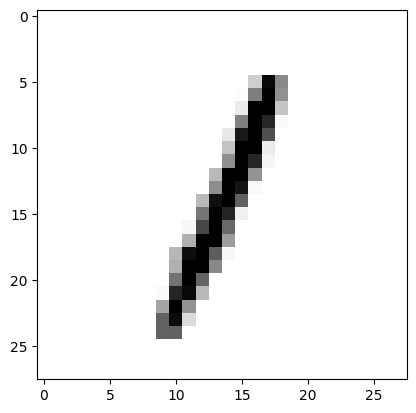

pred: 1, prob: 0.8 true: 1


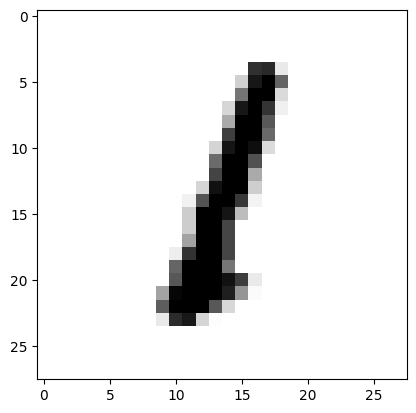

pred: 1, prob: 0.82 true: 1


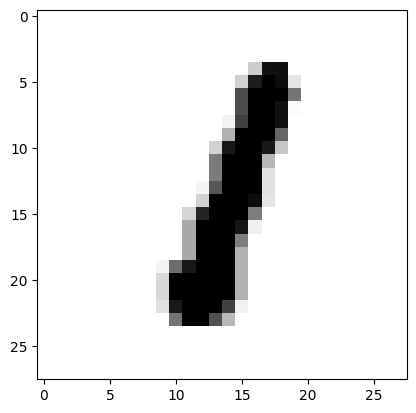

pred: 1, prob: 0.75 true: 1


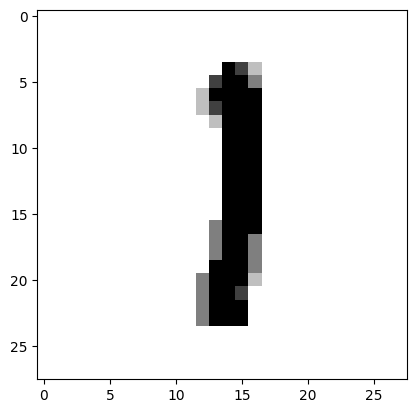

pred: 1, prob: 0.74 true: 1


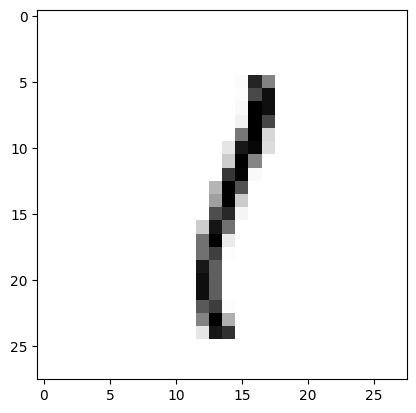

pred: 0, prob: 0.61 true: 0


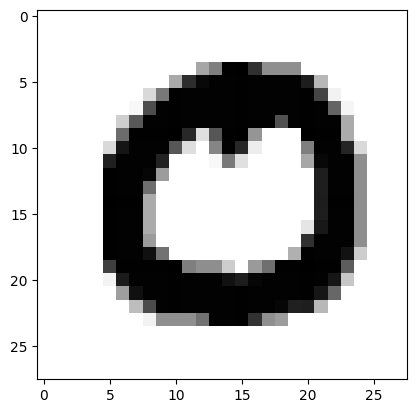

pred: 0, prob: 0.8 true: 0


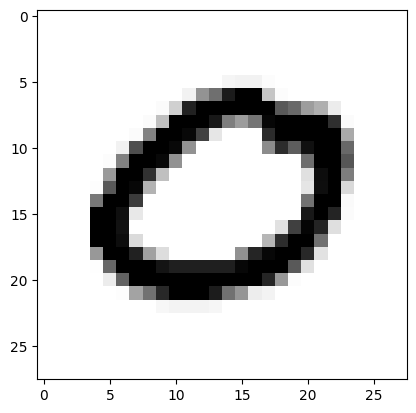

pred: 1, prob: 0.74 true: 1


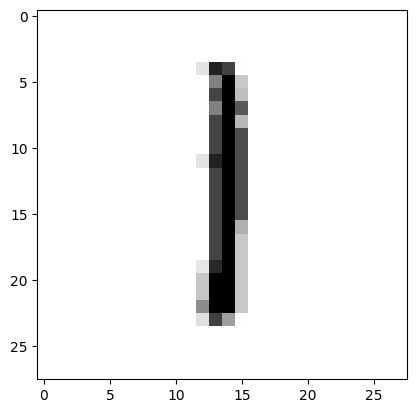

pred: 1, prob: 0.79 true: 1


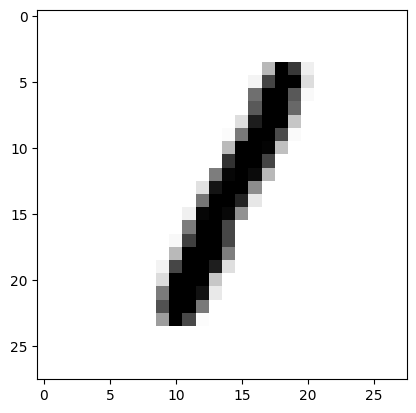

pred: 1, prob: 0.73 true: 1


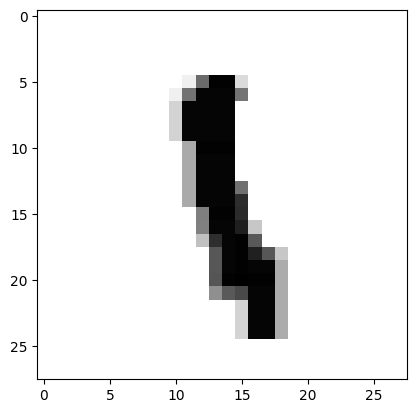

pred: 0, prob: 0.74 true: 0


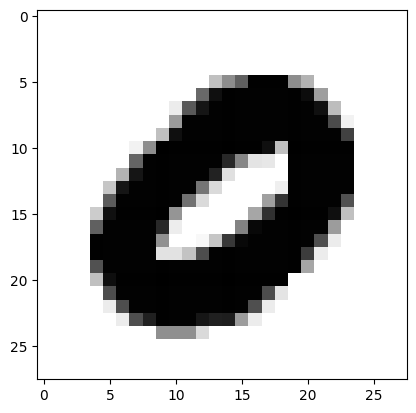

pred: 0, prob: 0.84 true: 0


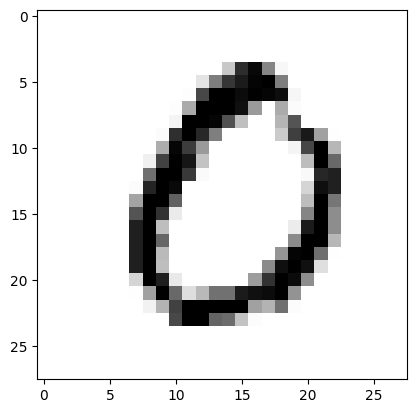

pred: 1, prob: 0.75 true: 1


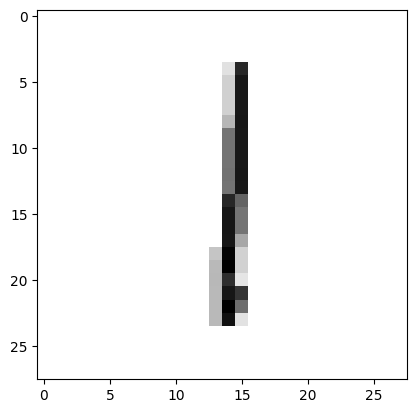

pred: 0, prob: 0.79 true: 0


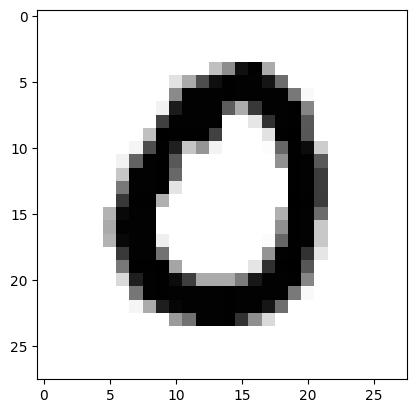

pred: 0, prob: 0.8 true: 0


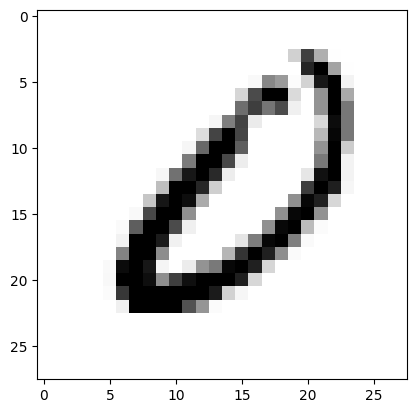

In [ ]:
# Display some Images for checking
for image_test in test_rdd.map(lambda x: (x[0], predict(x[0], W1, B1, W2, B2), np.argmax(x[1]))).takeSample(False, 15):

    pred = np.argmax(image_test[1])
    print(f'pred: {pred}, prob: {round(image_test[1][0][pred], 2)} true: {image_test[2]}')
    image = np.reshape(image_test[0], (28, 28))
    plt.imshow(image, cmap='binary')
    plt.show()